<a href="https://colab.research.google.com/github/HalitovskyiSerhii/ABAE/blob/master/ABAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torchtext spacy -U

In [0]:
!wget https://github.com/thedenaas/hse_seminars/raw/master/2018/seminar_13/data.zip
!ls

In [0]:
!unzip data.zip -d data 

In [0]:
import math

import nltk
import numpy as np
import gensim
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import init
from torch import optim
from torchtext.data import Field, BucketIterator, Dataset, TabularDataset, Iterator

import spacy

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [0]:
raw_documents = []
snippets = []
with open( "data/data.txt", "r") as f:
    for line in f.readlines():
        text = line
        raw_documents.append( text.lower() )
        
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))
raw_documents[0]

Read 4551 raw text documents


"barclays' defiance of us fines has merit barclays disgraced itself in many ways during the pre-financial crisis boom years. so it is tempting to think the bank, when asked by us department of justice to pay a large bill for polluting the financial system with mortgage junk between 2005 and 2007, should cough up, apologise and learn some humility. that is not the view of the chief executive, jes staley. barclays thinks the doj’s claims are “disconnected from the facts” and that it has “an obligation to our shareholders, customers, clients and employees to defend ourselves against unreasonable allegations and demands.” the stance is possibly foolhardy, since going into open legal battle with the most powerful us prosecutor is risky, especially if you end up losing. but actually, some grudging respect for staley and barclays is in order. the us system for dishing out fines to errant banks for their mortgage sins has come to resemble a casino. the approach prefers settlements behind close

In [0]:

# custom stopwords
custom_stop_words = ['<eos>']
with open( "data/stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )

print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 351 entries


In [0]:
spacy_en = spacy.load('en')
spacy_en.remove_pipe('tagger')
spacy_en.remove_pipe('ner')

# print([tok.lemma_ for tok in spacy_en.tokenizer(raw_documents[0]) if tok.text.isalpha()])

def tokenizer(text): # create a tokenizer function
    return [tok.lemma_ for tok in spacy_en.tokenizer(text) 
    if tok.text.isalpha() and len(tok.lemma_)>1 and tok.lemma_ not in ['\ufeff1']]

In [0]:
TEXT = Field(include_lengths=False, batch_first=True,
             tokenize = tokenizer,
             eos_token = '<eos>',
             lower=True,
             stop_words=custom_stop_words#nltk.corpus.stopwords.words('english')
            )

dataset = TabularDataset('data/data.txt', format='csv', fields=[('text', TEXT)])

In [0]:
TEXT.build_vocab(dataset, min_freq=1)
terms = TEXT.vocab.itos
len(TEXT.vocab.itos), TEXT.vocab.itos[:10]

(11764,
 ['<unk>',
  '<pad>',
  '<eos>',
  'trump',
  'bank',
  '-pron-',
  'review',
  'city',
  'donald',
  'brexit'])

In [0]:
batch_size = 32
n_neg = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(TEXT.vocab.itos)
d = 200

In [0]:
train_iterator, = BucketIterator.splits(
    (dataset,),
    batch_sizes=(batch_size,),
    shuffle=True, device=device,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
)
neg_iterator,  = BucketIterator.splits(
    (dataset,), batch_sizes=(n_neg,),
    shuffle=True, device=device,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
)
all_iterator,  = BucketIterator.splits(
    (dataset,), batch_sizes=(len(dataset),),
    device=device,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
)
one_iterator,  = BucketIterator.splits(
    (dataset,), batch_sizes=(1,),
    device=device,
    sort_within_batch=False,
)


In [0]:
class IterWrapper():
  def __init__(self, bucket_iter):
    self.bi=bucket_iter

  def __iter__(self):
    for x in self.bi:
      for doc in x.text:
        yield [TEXT.vocab.itos[w] for w in doc]

w2v_model = gensim.models.Word2Vec(IterWrapper(one_iterator), size=500, min_count=0, sg=1)
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 11762 terms


In [0]:
def usqz(t:torch.Tensor,dim):
    return t.unsqueeze(dim)
    
class Model(nn.Module):


  def __init__(self, vocab_size, d, T_size, neg_iterator, l=0.25,*args,**kwargs):
    super(Model, self).__init__(*args,**kwargs)
    self.neg_iterator = neg_iterator 
    self.neg_iter = iter(neg_iterator)
    self.vocab_size = vocab_size
    self.d = d
    self.T_size = T_size
    self.l=l
    self.emb = nn.Embedding(vocab_size, d)
    self.M = Parameter(torch.Tensor(d,d))
    self.T = Parameter(torch.Tensor(T_size, d))
    self.W = Parameter(torch.Tensor(T_size,d))
    self.b = Parameter(torch.Tensor(T_size))
    self.z = 0 
    self.r = 0
    self.zero = torch.FloatTensor()
    self.one = torch.FloatTensor()

    self.reset_parameters()

  def reset_parameters(self):
      init.kaiming_uniform_(self.M, a=math.sqrt(5))
      init.kaiming_uniform_(self.T, a=math.sqrt(5))
      init.kaiming_uniform_(self.W, a=math.sqrt(5))
      fan_in, _ = init._calculate_fan_in_and_fan_out(self.W)
      bound = 1 / math.sqrt(fan_in)
      init.uniform_(self.b, -bound, bound)
  
  @property
  def device(self):
    return next(self.parameters()).device

  def next_neg(self):
    try:
      return next(self.neg_iter)
    except StopIteration:
      self.neg_iter = iter(self.neg_iterator)
      return next(self.neg_iter)

  def calc_loss(self):
      x = self.next_neg()
      n = self.emb(x.text).mean(dim=1)

      r_size, n_size = self.r.shape[0], n.shape[0]
      c_size = r_size*n_size
      if self.zero.shape != (c_size,c_size):
        self.zero = torch.zeros((c_size,c_size),device=self.device)
      if self.one.shape != (c_size,c_size):
        self.one = torch.ones((c_size,c_size),device=self.device)

      J = torch.max(self.zero, 
                    self.one - self.r.repeat(n.shape[0],1)
                    .matmul(self.z.repeat(n.shape[0],1).t())
                    + self.r.repeat(n.shape[0],1)
                    .matmul(n.repeat(self.r.shape[0],1).t())
                    ).sum(axis=1).mean()

      U = torch.norm((self.T.t().mm(self.T) - 
                      self.d*torch.eye(self.d, device=self.device)).mean())
      # print(J, U)
      L = J + self.l*U
      return L

  def forward(self,x):
    x = x.text
    # print(x.shape)
    e = self.emb(x)
    # print(e.shape)
    y_s=usqz(e.mean(axis=1),-1)
    # print(y_s.shape)
    d = e.matmul(self.M.matmul(y_s))
    # print(d.shape)
    a = usqz(F.softmax(d.squeeze(-1),dim=1),1)
    # print('a', a.shape)
    self.z=a.matmul(e).squeeze(-2)
    # print('z', self.z.shape)
    p = F.softmax(self.z.matmul(self.W.t())+self.b,dim=1).squeeze(-2)
    # print('p', p.shape)
    self.r = self.T.t().matmul(usqz(p,-1)).squeeze(-1)
    # print('r', self.r.shape)
    return self.r
    


In [0]:
from IPython import display
import sys

def train(model, T, epochs=1):
  output = "\r"
  output += 4*"#"+f"Model with {T} topics" + 4*"#" + " "
  if model.device!=device:
    model.to(device)
  opt = optim.Adam(model.parameters())

  for epoch in range(1,epochs+1):
    o = output + f"{epoch}/{epochs}: "
    for i, batch in enumerate(train_iterator):
      opt.zero_grad()
      model(batch)
      loss=model.calc_loss()
      if i%10 ==0:
        # display.clear_output(wait=False)
        sys.stdout.write(o+f'loss:{loss.item()}')
      loss.backward()
      opt.step()
  print()
  return model


In [0]:
m = train(Model(vocab_size,d, 10, neg_iterator, l=0.2),10,epochs=2)

####Model with 10 topics#### 2/2: loss:0.19998590648174286


In [0]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms


def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

In [0]:
with torch.no_grad():
  H_rez = m.T.matmul(m.emb.weight.t()).cpu().numpy()

  descriptors = []
  for topic_index in range(10):
      descriptors.append( get_descriptor( terms, H_rez, topic_index, 10 ) )
      str_descriptor = ", ".join( descriptors[topic_index] )
      print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )
  print('\n\n')
  W_rez = m.emb(next(iter(all_iterator)).text).matmul(m.T.t()).mean(dim=-2) \
    .cpu().numpy()
  topic_snippets = get_top_snippets( snippets, W_rez , 0, 10 )
  for i, snippet in enumerate(topic_snippets):
      print("%02d. %s" % ( (i+1), snippet ) )

Topic 01: <eos>, amazing, unescapable, provider, posner, stevenage, damas, primavera, ere, chickenpox
Topic 02: <eos>, additional, cartel, carefully, loneliness, diy, zine, saido, gush, france
Topic 03: zika, gripe, island, confuse, bookshop, privilege, refusal, ifs, beef, anorexia
Topic 04: <eos>, shambolic, shangri, scottish, figure, naysayer, sulk, robin, jackson, albion
Topic 05: goings, procedure, clay, greasy, algeria, sic, whoop, intentionally, marvin, imarhan
Topic 06: austrian, osborne, ozark, bon, kaepernick, peter, vanguard, promising, chief, sweat
Topic 07: <eos>, discriminatory, snarl, atm, philippa, bibio, individualist, float, beloved, diversity
Topic 08: zest, <eos>, gun, swift, innovations, previously, dismissal, auguste, pops, unintended
Topic 09: <eos>, airline, leftfield, reparations, bumper, provision, starlet, techcrunch, stingy, boogie
Topic 10: wreck, grammy, sara, straightforwardly, <eos>, bicker, disappointed, officer, calls, waterloo



01. Barclays' defiance

In [0]:
topic_models = []
topics_k = [4, 8, 10, 15]
for t in [4, 8, 10, 15]:
    model = Model(vocab_size,d, t, neg_iterator)
    model = train(model,t, epochs=t//4)
    with torch.no_grad():
      W = model.emb(next(iter(all_iterator)).text).matmul(model.T.t()) \
        .mean(dim=-2).cpu().numpy()
      H = model.T.matmul(model.emb.weight.t()).cpu().numpy()
    topic_models.append( (t,W,H) )

####Model with 4 topics#### 1/1: loss:3.5557711124420166
####Model with 8 topics#### 2/2: loss:0.24997958540916443
####Model with 10 topics#### 2/2: loss:0.24997933208942413
####Model with 15 topics#### 3/3: loss:0.2499600052833557


In [0]:
# missmatch=[]
# for w in TEXT.vocab.itos:
#   if w not in vectorizer.vocabulary_:
#     missmatch.append(w)
# missmatch

In [0]:
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.vocab and pair[1] in w2v_model.wv.vocab:
              pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    print(H.shape)
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

(4, 11764)
K=04: Coherence=0.9715
(8, 11764)
K=08: Coherence=0.9721
(10, 11764)
K=10: Coherence=0.9820
(15, 11764)
K=15: Coherence=0.9833


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


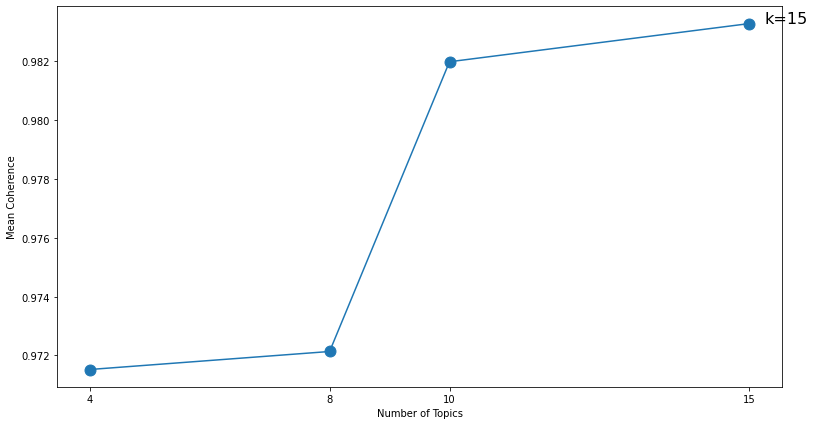

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()